# The report is available at the end of the notebook

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from matplotlib import pyplot as plt
from gensim.models import KeyedVectors
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import GridSearchCV

word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Data Exploration

In [2]:
data = pd.read_csv('deepnlp/Sheet_1.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
response_id      80 non-null object
class            80 non-null object
response_text    80 non-null object
Unnamed: 3       2 non-null object
Unnamed: 4       0 non-null float64
Unnamed: 5       1 non-null object
Unnamed: 6       0 non-null float64
Unnamed: 7       1 non-null object
dtypes: float64(2), object(6)
memory usage: 5.1+ KB


In [4]:
data.head(10)

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN
5,response_6,not_flagged,a couple of years ago my friends was going to ...,NaN,NaN,NaN,NaN,NaN
6,response_7,flagged,Roommate when he was going through death and l...,NaN,NaN,NaN,NaN,NaN
7,response_8,flagged,i've had a couple of friends (you could say mo...,NaN,NaN,NaN,NaN,NaN
8,response_9,not_flagged,Listened to someone talk about relationship tr...,NaN,NaN,NaN,NaN,NaN
9,response_10,flagged,I will always listen. I comforted my sister wh...,NaN,NaN,NaN,NaN,NaN


In [5]:
data.describe()

,Unnamed: 4,Unnamed: 6
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [6]:
print('data size: ', len(data))
data.count()

data size:  80


response_id      80
class            80
response_text    80
Unnamed: 3        2
Unnamed: 4        0
Unnamed: 5        1
Unnamed: 6        0
Unnamed: 7        1
dtype: int64

In [7]:
#remove the Unnamed cols
data = data[['response_id','response_text', 'class']]

In [8]:
data

,response_id,response_text,class
0,response_1,I try and avoid this sort of conflict,not_flagged
1,response_2,Had a friend open up to me about his mental ad...,flagged
2,response_3,I saved a girl from suicide once. She was goin...,flagged
3,response_4,i cant think of one really...i think i may hav...,not_flagged
4,response_5,Only really one friend who doesn't fit into th...,not_flagged
5,response_6,a couple of years ago my friends was going to ...,not_flagged
6,response_7,Roommate when he was going through death and l...,flagged
7,response_8,i've had a couple of friends (you could say mo...,flagged
8,response_9,Listened to someone talk about relationship tr...,not_flagged
9,response_10,I will always listen. I comforted my sister wh...,flagged


In [9]:
data['class'].value_counts()

not_flagged    55
flagged        25
Name: class, dtype: int64

In [10]:
responses = data['response_text']
classification = data['class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(responses, classification, test_size=0.3)

# Feature Selection

In [12]:

def get_tfIDF(responses, max_features=300):  
    tfIdf_vectorizer = TfidfVectorizer(max_features)
    transformed_data = tfIdf_vectorizer.fit_transform(responses).toarray()
    return transformed_data, tfIdf_vectorizer

def get_count_vectors(responses):  
    count_vectorizer = CountVectorizer()
    transformed_data = count_vectorizer.fit_transform(responses).toarray()
    return transformed_data, count_vectorizer

def get_co_occurence_matrix(responses, ngram_range):
    count_vectorizer = CountVectorizer(ngram_range=ngram_range)
    transformed_data = count_vectorizer.fit_transform(responses).toarray()
    return transformed_data, count_vectorizer

def preform_LSA(word_vectors, n_components=2):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    transformed_data = svd.fit_transform(word_vectors)
    return transformed_data, svd

def get_word2vec_avg(responses, pretrained_model=word2vec_model):
    tokenizer = RegexpTokenizer(r'\w+')
    result = []
    for response in responses:
        words = tokenizer.tokenize(response)
        vectors_sum = np.zeros((300,),dtype="float32")
        count = 0
        for word in words:
            try:
                vectors_sum += pretrained_model[word]
                count += 1
            except KeyError:
                continue
        vectors_avg = vectors_sum / count
        result.append(vectors_avg)
    return np.array(result), None

In [13]:
get_word2vec_avg(X_train)[0].shape

(56, 300)

# Visulaization

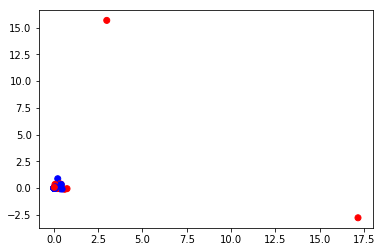

In [14]:
data = preform_LSA(get_co_occurence_matrix(X_train, ngram_range=(2,2))[0])[0]
colors = ['b' if c == 'not_flagged' else 'r' for c in y_train]
plt.scatter(data[:,0], data[:,1], c=colors)

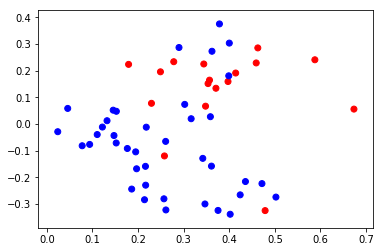

In [15]:
data = preform_LSA(get_tfIDF(X_train)[0])[0]
plt.scatter(data[:,0], data[:,1], c=colors)

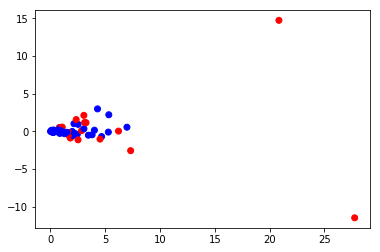

In [16]:
data = preform_LSA(get_count_vectors(X_train)[0])[0]
plt.scatter(data[:,0], data[:,1], c=colors)

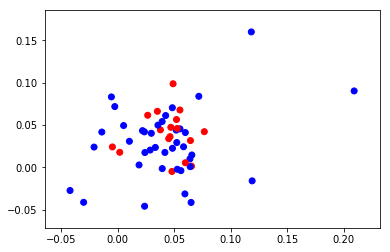

In [17]:
data = get_word2vec_avg(X_train)[0]
plt.scatter(data[:,0], data[:,1], c=colors)

# Model Building

In [18]:
def fit_model(responses, classification, data_transformer=None, data_transformer_args=None,
              classifier="SVM", nfold=5):
    clf = None
    precision = []
    recall = []
    fscore = []
    accuracies = []

    if classifier == "RF":
        clf = RandomForestClassifier(max_depth=10,max_features=10)
    elif classifier == "MNB":
        clf = MultinomialNB()
    elif classifier == "GNB":
        clf = GaussianNB()
    elif classifier == "SVM":
        clf = LinearSVC()
    
    skf = StratifiedKFold(n_splits=nfold)
    #apply cross validation
    for train_index, test_index in skf.split(responses, classification):
        X_train, X_test = responses[train_index], responses[test_index]
        y_train, y_test = classification[train_index], classification[test_index]
        if data_transformer_args:
            X_train_vectorized, test_data_transformer = data_transformer(X_train, data_transformer_args)
        else:
            X_train_vectorized, test_data_transformer = data_transformer(X_train)
        if test_data_transformer:
            X_test_vectorized = test_data_transformer.transform(X_test)
        else:
            X_test_vectorized = data_transformer(X_test)[0]
        model = clf.fit(X_train_vectorized, y_train)
        y_pred = model.predict(X_test_vectorized)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precision.append(p)
        recall.append(r)
        fscore.append(f)
        accuracies.append(accuracy_score(y_test, y_pred))
        
    return np.mean(precision), np.mean(recall), np.mean(fscore), np.mean(accuracies)

In [19]:
import itertools
grid_search = []
classifiers = ['SVM', 'GNB', 'MNB', 'RF']
tf_idf_args = [2, 5, 20, 50, 100, 150, 200, 300, 350, 400]
tf_idf = ['tf_IDF']
grid_search.extend(list(itertools.product(tf_idf, tf_idf_args, classifiers)))
co_occurence_matrix_args = [(1,1), (2,2), (3,3), (4,4)]
co_occurence_matrix = ['co_occurence_matrix']
grid_search.extend(list(itertools.product(co_occurence_matrix, co_occurence_matrix_args, classifiers)))
word2vec_avg_args = [None]
word2vec_avg = ['word2vec_avg']
grid_search.extend(list(itertools.product(word2vec_avg, word2vec_avg_args, classifiers)))
grid_search

[('tf_IDF', 2, 'SVM'),
 ('tf_IDF', 2, 'GNB'),
 ('tf_IDF', 2, 'MNB'),
 ('tf_IDF', 2, 'RF'),
 ('tf_IDF', 5, 'SVM'),
 ('tf_IDF', 5, 'GNB'),
 ('tf_IDF', 5, 'MNB'),
 ('tf_IDF', 5, 'RF'),
 ('tf_IDF', 20, 'SVM'),
 ('tf_IDF', 20, 'GNB'),
 ('tf_IDF', 20, 'MNB'),
 ('tf_IDF', 20, 'RF'),
 ('tf_IDF', 50, 'SVM'),
 ('tf_IDF', 50, 'GNB'),
 ('tf_IDF', 50, 'MNB'),
 ('tf_IDF', 50, 'RF'),
 ('tf_IDF', 100, 'SVM'),
 ('tf_IDF', 100, 'GNB'),
 ('tf_IDF', 100, 'MNB'),
 ('tf_IDF', 100, 'RF'),
 ('tf_IDF', 150, 'SVM'),
 ('tf_IDF', 150, 'GNB'),
 ('tf_IDF', 150, 'MNB'),
 ('tf_IDF', 150, 'RF'),
 ('tf_IDF', 200, 'SVM'),
 ('tf_IDF', 200, 'GNB'),
 ('tf_IDF', 200, 'MNB'),
 ('tf_IDF', 200, 'RF'),
 ('tf_IDF', 300, 'SVM'),
 ('tf_IDF', 300, 'GNB'),
 ('tf_IDF', 300, 'MNB'),
 ('tf_IDF', 300, 'RF'),
 ('tf_IDF', 350, 'SVM'),
 ('tf_IDF', 350, 'GNB'),
 ('tf_IDF', 350, 'MNB'),
 ('tf_IDF', 350, 'RF'),
 ('tf_IDF', 400, 'SVM'),
 ('tf_IDF', 400, 'GNB'),
 ('tf_IDF', 400, 'MNB'),
 ('tf_IDF', 400, 'RF'),
 ('co_occurence_matrix', (1, 1), '

In [ ]:
feature_extractors_dict = { 'tf_IDF': get_tfIDF,
                           'co_occurence_matrix': get_co_occurence_matrix,
                           'word2vec_avg': get_word2vec_avg}
results = []
for feature_extractor, feature_extractor_args, classifier in grid_search:
    try:
        precision, recall, fscore, accuracy = fit_model(responses, classification, 
                                                        data_transformer=feature_extractors_dict[feature_extractor], 
                                                        data_transformer_args=feature_extractor_args,
                                                        classifier=classifier, nfold=5)
    except Exception:
        continue
    result = {'feature_extractor': feature_extractor,
              'feature_extractor_args': feature_extractor_args,
              'classifier': classifier,
              'precision': precision,
              'recall': recall,
              'fscore': fscore,
              'accuracy': accuracy}
    results.append(result)

In [21]:
results = pd.DataFrame(results)
print(results)

    accuracy classifier    feature_extractor feature_extractor_args    fscore  \
0     0.7625        SVM               tf_IDF                      2  0.746154   
1     0.6875        MNB               tf_IDF                      2  0.560185   
2     0.7125         RF               tf_IDF                      2  0.665918   
3     0.7625        SVM               tf_IDF                      5  0.746154   
4     0.6875        MNB               tf_IDF                      5  0.560185   
5     0.6625         RF               tf_IDF                      5  0.588159   
6     0.7625        SVM               tf_IDF                     20  0.746154   
7     0.6875        MNB               tf_IDF                     20  0.560185   
8     0.6625         RF               tf_IDF                     20  0.586819   
9     0.7625        SVM               tf_IDF                     50  0.746154   
10    0.6875        MNB               tf_IDF                     50  0.560185   
11    0.7125         RF     

In [22]:
#Highest Precision
results.loc[results['precision'].idxmax()]

accuracy                          0.75
classifier                         GNB
feature_extractor         word2vec_avg
feature_extractor_args            None
fscore                        0.758056
precision                     0.830159
recall                            0.75
Name: 43, dtype: object

In [23]:
#Highest FScore
results.loc[results['fscore'].idxmax()]

accuracy                        0.8125
classifier                         SVM
feature_extractor         word2vec_avg
feature_extractor_args            None
fscore                        0.803678
precision                     0.814484
recall                          0.8125
Name: 42, dtype: object

In [29]:
#Highest recall
results.loc[results['recall'].idxmax()]

accuracy                        0.8125
classifier                         SVM
feature_extractor         word2vec_avg
feature_extractor_args            None
fscore                        0.803678
precision                     0.814484
recall                          0.8125
Name: 42, dtype: object

In [30]:
#Highest accuracy
results.loc[results['accuracy'].idxmax()]

accuracy                        0.8125
classifier                         SVM
feature_extractor         word2vec_avg
feature_extractor_args            None
fscore                        0.803678
precision                     0.814484
recall                          0.8125
Name: 42, dtype: object

# Model Evaluation Metrics

I will go with the model having the highest recall score, because if a user response have a true label(flagged), we would want our system to pick it up for sure. We would rather have false positives than false negatives.

# Description of the models evaluated

- I only evaluated three models: Random Forests, Naive Bayes and SVM (I chose these three primarily because of the size of the data)
- It would be interesting to try out a deep learning model if we had more data (LSTM model with some sort of attention mechanism would be interesting to evaluate)

# Feature Extraction Techniques

- I don't have much experience with feature extraction in language, so I referred to several tutorials for this task
- I evaluated term frequency inverse document frequency, term frequency, co-occurence matrix, latent semantic analysis and pretrained Word2Vec for feature extraction
- I referred to this mostly http://aqibsaeed.github.io/2016-07-26-text-classification/

# Tuning Strategy

- Feature extraction parameters were chosen by doing a grid search over them
- I assumed the default parameters for the classifiers
- It would be nice to try out Random Search
- TODO: grid search over the classifiers hyperparameters

# Notes

- This was an interesting challenge since I haven't worked with NLP before.
- I am not sure what is the expectation here (in terms of, if I should submit a working model or try to beat a certain accuracy?)
- There is a lot more that can be done and experimented with but I am not sure if it's in the scope of this challenge
- Having more data would have helped, since I would have been able to experiment with different Neural Networks Architectures.